# 1 Network Characteristics

In [40]:
import snap
import numpy as np
import matplotlib.pyplot as plt

## 1.0 Generate & Read Graphs

In [45]:
def index_to_edge(index, N=5242):
    """
    convert an index to edge tuple
    all tuples are aligned as followed: 
    (0, 1), (1, 2), (2, 3), ..., (N-1, 0)
    (0, 2), (1, 3), (2, 4), ..., (N-1, 1)
    ...
    (0, N/2), (1, N/2+1), ...
    This can be used in both Erdos Renyi and Small World
    """
    row = index // N
    col = index % N
    return int(col), int((col + row + 1) % N)

Erdos-Renyi Random Graph

In [46]:
def genErdosRenyi(N=5242, E=14484):
    """
    :param - N: number of nodes
    :param - E: number of edges

    return type: snap.PUNGraph
    return: Erdos-Renyi graph with N nodes and E edges
    """
    # Initialize a graph
    Graph = snap.TUNGraph.New()
    
    # Add N nodes, indices from 0 to N - 1
    for Id in range(N):
        Graph.AddNode(Id)
        
    # Randomly select E edges by indices
    indices = np.random.choice(int(N * (N - 1) / 2), E, replace=False)
    
    # Convert indices to tuples (src, dst)
    for index in indices:
        src, dst = index_to_edge(index, N)
        Graph.AddEdge(src, dst)
        
    return Graph

In [62]:
erdosRenyi = genErdosRenyi()

Small-World Random Network

In [55]:
def genSmallWorld(N=5242, E=14484):
    """
    :param - N: number of nodes
    :param - E: number of edges

    return type: snap.PUNGraph
    return: Small-World graph with N nodes and E edges
    """
    Graph = snap.TUNGraph.New()
    
    # Add N nodes, indices from 0 to N - 1
    for Id in range(N):
        Graph.AddNode(Id)
    
    # genCircle & connectNbrOfNbr
    for Id in range(N):
        Graph.AddEdge(Id, (Id + 1) % N)
        Graph.AddEdge(Id, (Id + 2) % N)
    
    # Randomly select E edges by indices
    indices = np.random.choice(int(N * (N - 1) / 2 - 2 * N), E - 2 * N, replace=False)
    indices = indices + 2 * N
    # Convert indices to tuples (src, dst)
    for index in indices:
        src, dst = index_to_edge(index, N)
        Graph.AddEdge(src, dst)
    return Graph

In [95]:
smallWorld = genSmallWorld()

Real-World Collaboration Network

In [64]:
def loadCollabNet(path='ca-GrQc.txt'):
    """
    :param - path: path to edge list file

    return type: snap.PUNGraph
    return: Graph loaded from edge list at `path and self edges removed

    Do not forget to remove the self edges!
    """
    Graph = snap.LoadEdgeList(snap.PUNGraph, path, 0, 1)
    snap.DelSelfEdges(Graph)
    return Graph

In [65]:
collabNet = loadCollabNet()

## 1.1 Degree Distribution

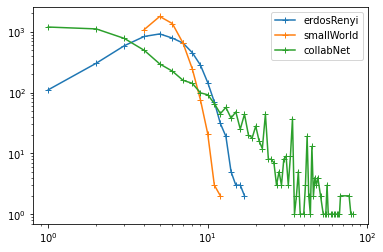

In [96]:
for G, name in zip([erdosRenyi, smallWorld, collabNet], ['erdosRenyi', 'smallWorld', 'collabNet']):
    DegToCntV = snap.TIntPrV()
    snap.GetOutDegCnt(G, DegToCntV)
    degrees = np.array([p.GetVal1() for p in DegToCntV if p.GetVal1() > 0])
    counts = np.array([p.GetVal2() for p in DegToCntV if p.GetVal1() > 0])
    plt.plot(degrees, counts, '+-', label=name)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

- Erdos-Renyi Random Graph has an approximately binomial degree distribution
- Small World Network has a minimum degree of 4, has the narrowest distribution. It degree distribution is appoximately (4 + binomial distribution)
- CollabNet has the widest distrubution

## 1.2 Clustering Coefficient

In [86]:
def GetClustCf(Graph):
    sum_clust_cf = 0.0
    for node in Graph.Nodes():
        degree = node.GetDeg()
        e = 0
        if degree <= 1:
            continue
        neighbor_ids = [node.GetNbrNId(i) for i in range(degree)]
        for i in range(degree - 1):
            for j in range(i + 1, degree):
                if Graph.IsEdge(neighbor_ids[i], neighbor_ids[j]):
                    e += 1
        sum_clust_cf += 2 * e / (degree * (degree - 1))
    return sum_clust_cf / Graph.GetNodes()

0.529635811052136

In [87]:
print(GetClustCf(collabNet), snap.GetClustCf (collabNet, -1))

0.529635811052136 0.5296358110521371


The answer is the same as snap built-in function

In [97]:
for G, name in zip([erdosRenyi, smallWorld, collabNet], ['erdosRenyi', 'smallWorld', 'collabNet']):
    print('%s: %f' % (name, GetClustCf(G)))

erdosRenyi: 0.001191
smallWorld: 0.282941
collabNet: 0.529636


Collaboration Network has the largest average clustering coefficient. Maybe in real world, collaborators tends to be in a same research group, or an article may have more than 2 authors. 